In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
from google.colab import files
uploaded = files.upload()

df_train = pd.read_csv("ECG5000_TRAIN.txt", delim_whitespace=True, header=None)
df_test = pd.read_csv("ECG5000_TEST.txt", delim_whitespace=True, header=None)
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df[0] = df[0].apply(lambda x: 0 if x == 1 else 1)  # 0 = normal, 1 = anomalie


print(df.shape)
print(df.head())



Saving ECG5000.txt to ECG5000.txt
Saving ECG5000_TEST.arff to ECG5000_TEST.arff
Saving ECG5000_TEST.ts to ECG5000_TEST.ts
Saving ECG5000_TEST.txt to ECG5000_TEST.txt
Saving ECG5000_TRAIN.arff to ECG5000_TRAIN.arff
Saving ECG5000_TRAIN.ts to ECG5000_TRAIN.ts
Saving ECG5000_TRAIN.txt to ECG5000_TRAIN.txt
(5000, 141)
   0         1         2         3         4         5         6         7    \
0    0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1    0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2    0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3    0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4    0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9    ...       131       132       133       134       135  \
0 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  ...  0.560327  0.538

<ipython-input-2-0f4cc13efc11>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv("ECG5000_TRAIN.txt", delim_whitespace=True, header=None)
<ipython-input-2-0f4cc13efc11>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv("ECG5000_TEST.txt", delim_whitespace=True, header=None)


In [3]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_cnn = torch.tensor(X_scaled).float().unsqueeze(1)
X_lstm = torch.tensor(X_scaled).float().unsqueeze(2)
y_tensor = torch.tensor(y).long()
assert y_tensor.min() >= 0 and y_tensor.max() <= 1, "Erreur : y_tensor contient des valeurs hors [0, 1]"

print("Valeurs uniques dans y :", y_tensor.unique())


Xc_train, Xc_test, Xl_train, Xl_test, y_train, y_test = train_test_split(
    X_cnn, X_lstm, y_tensor, test_size=0.2, random_state=42, stratify=y)

batch_size = 64
train_loader_cnn = DataLoader(TensorDataset(Xc_train, y_train), batch_size=batch_size, shuffle=True)
test_loader_cnn = DataLoader(TensorDataset(Xc_test, y_test), batch_size=batch_size)
train_loader_lstm = DataLoader(TensorDataset(Xl_train, y_train), batch_size=batch_size, shuffle=True)
test_loader_lstm = DataLoader(TensorDataset(Xl_test, y_test), batch_size=batch_size)


Valeurs uniques dans y : tensor([0, 1])


In [11]:
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 2)
    def forward(self, x):
        print("Input shape:", x.shape)  # Add print statement for input shape
        x = torch.relu(self.conv1(x))
        print("After conv1:", x.shape)  # Add print statement after conv1
        x = torch.relu(self.conv2(x))
        print("After conv2:", x.shape)  # Add print statement after conv2
        x = self.pool(x).squeeze(-1)
        print("After pool:", x.shape)  # Add print statement after pool
        x = self.drop(x)
        print("After dropout:", x.shape)  # Add print statement after dropout
        return self.fc(x)

class LSTM1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 2)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.drop(h_n[-1])
        return self.fc(x)


In [19]:
def train_model(model, train_loader, test_loader, epochs=100):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    best_auc = 0
    best_model_state = None

    train_losses = []
    val_aucs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            out = model(xb)

            # 🔍 Sécurité
            assert not torch.isnan(out).any(), "Erreur : sortie du modèle contient NaN"
            assert out.shape[1] == 2, f"Erreur : sortie inattendue du modèle, shape = {out.shape}"
            assert yb.min() >= 0 and yb.max() <= 1, f"Erreur : labels hors [0, 1] : {yb.unique()}"

            loss = criterion(out, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()

        train_losses.append(total_loss / len(train_loader))

        # Évaluation AUC
        model.eval()
        all_probs = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in test_loader:
                probs = torch.softmax(model(xb.to(device)), dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probs)
                all_labels.extend(yb.numpy())

        auc = roc_auc_score(all_labels, all_probs)
        val_aucs.append(auc)

        print(f"Epoch {epoch+1:2d} | Loss: {total_loss:.4f} | AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model_state = model.state_dict()

    # Tracer les courbes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='AUC sur test', color='orange')
    plt.xlabel("Époque")
    plt.ylabel("AUC")
    plt.title("Courbe d'AUC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.load_state_dict(best_model_state)
    return model, train_losses, val_aucs



In [20]:
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb.to(device))
            probs = torch.softmax(logits, dim=1)
            y_scores.extend(probs[:, 1].cpu().numpy())
            y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())
            y_true.extend(yb.numpy())

    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.title("Courbe ROC")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.hist([y_scores[i] for i in range(len(y_scores)) if y_true[i] == 0], bins=30, alpha=0.5, label='Classe 0 (normal)')
    plt.hist([y_scores[i] for i in range(len(y_scores)) if y_true[i] == 1], bins=30, alpha=0.5, label='Classe 1 (anomalie)')
    plt.title("Distribution des scores de probabilité")
    plt.xlabel("Score (proba classe 1)")
    plt.ylabel("Fréquence")
    plt.legend()
    plt.grid(True)
    plt.show()


In [21]:
def plot_training_curves(train_losses, val_aucs, title=""):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.title("Courbe de Loss" + title)
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='AUC sur test', color='orange')
    plt.xlabel("Époque")
    plt.ylabel("AUC")
    plt.title("Courbe d'AUC" + title)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
After pool: torch.Size([64, 64])
After dropout: torch.Size([64, 64])
Input shape: torch.Size([64, 1, 140])
After conv1: torch.Size([64, 32, 140])
After conv2: torch.Size([64, 64, 140])
After pool: torch.Size([64, 64])
After dropout: torch.Size([64, 64])
Input shape: torch.Size([64, 1, 140])
After conv1: torch.Size([64, 32, 140])
After conv2: torch.Size([64, 64, 140])
After pool: torch.Size([64, 64])
After dropout: torch.Size([64, 64])
Input shape: torch.Size([64, 1, 140])
After conv1: torch.Size([64, 32, 140])
After conv2: torch.Size([64, 64, 140])
After pool: torch.Size([64, 64])
After dropout: torch.Size([64, 64])
Input shape: torch.Size([64, 1, 140])
After conv1: torch.Size([64, 32, 140])
After conv2: torch.Size([64, 64, 140])
After pool: torch.Size([64, 64])
After dropout: torch.Size([64, 64])
Input shape: torch.Size([64, 1, 140])
After conv1: torch.Size([64, 32, 140])
After conv2: torch.Size([64, 64, 140

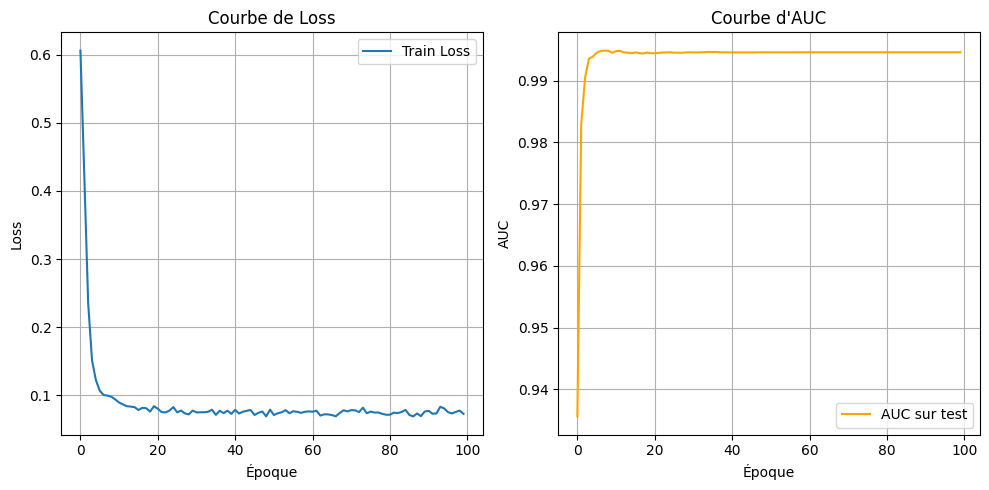

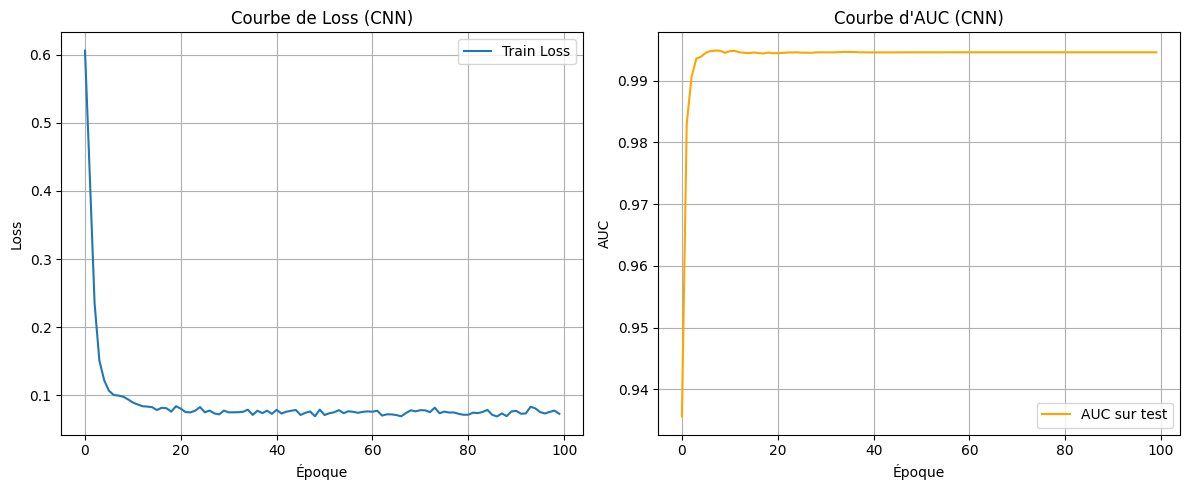

Epoch  1 | Loss: 28.4276 | AUC: 0.9561
Epoch  2 | Loss: 10.4745 | AUC: 0.9945
Epoch  3 | Loss: 6.7524 | AUC: 0.9976
Epoch  4 | Loss: 4.7811 | AUC: 0.9982
Epoch  5 | Loss: 3.9733 | AUC: 0.9986
Epoch  6 | Loss: 3.8538 | AUC: 0.9982
Epoch  7 | Loss: 3.4502 | AUC: 0.9987
Epoch  8 | Loss: 3.3033 | AUC: 0.9985
Epoch  9 | Loss: 3.3592 | AUC: 0.9991
Epoch 10 | Loss: 3.3294 | AUC: 0.9987
Epoch 11 | Loss: 3.1031 | AUC: 0.9985
Epoch 12 | Loss: 3.0486 | AUC: 0.9990
Epoch 13 | Loss: 2.7918 | AUC: 0.9989
Epoch 14 | Loss: 2.8248 | AUC: 0.9988
Epoch 15 | Loss: 2.8185 | AUC: 0.9991
Epoch 16 | Loss: 2.8511 | AUC: 0.9991
Epoch 17 | Loss: 2.7922 | AUC: 0.9990
Epoch 18 | Loss: 2.7180 | AUC: 0.9991
Epoch 19 | Loss: 2.6638 | AUC: 0.9991
Epoch 20 | Loss: 2.6538 | AUC: 0.9988
Epoch 21 | Loss: 2.5849 | AUC: 0.9990
Epoch 22 | Loss: 2.5092 | AUC: 0.9991
Epoch 23 | Loss: 2.5609 | AUC: 0.9992
Epoch 24 | Loss: 2.6668 | AUC: 0.9991
Epoch 25 | Loss: 2.5556 | AUC: 0.9992
Epoch 26 | Loss: 2.4854 | AUC: 0.9991
Epoch 27 |

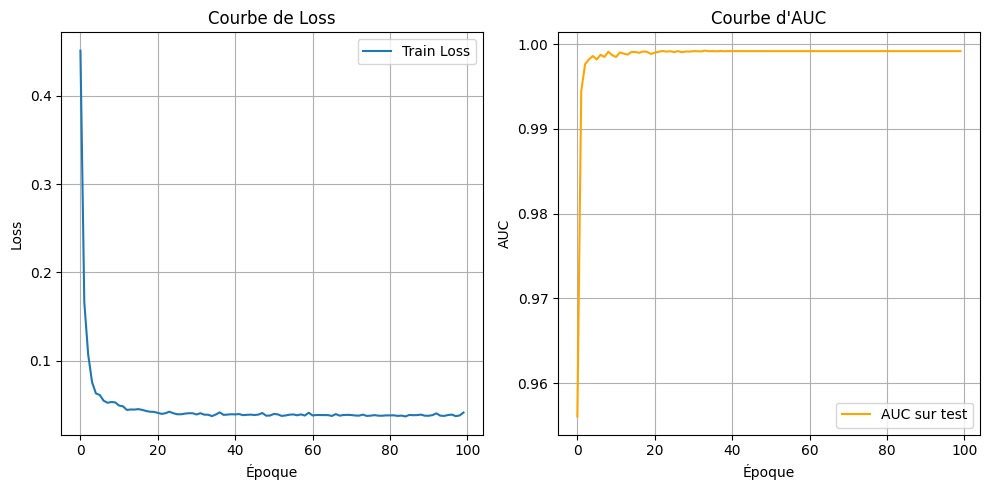

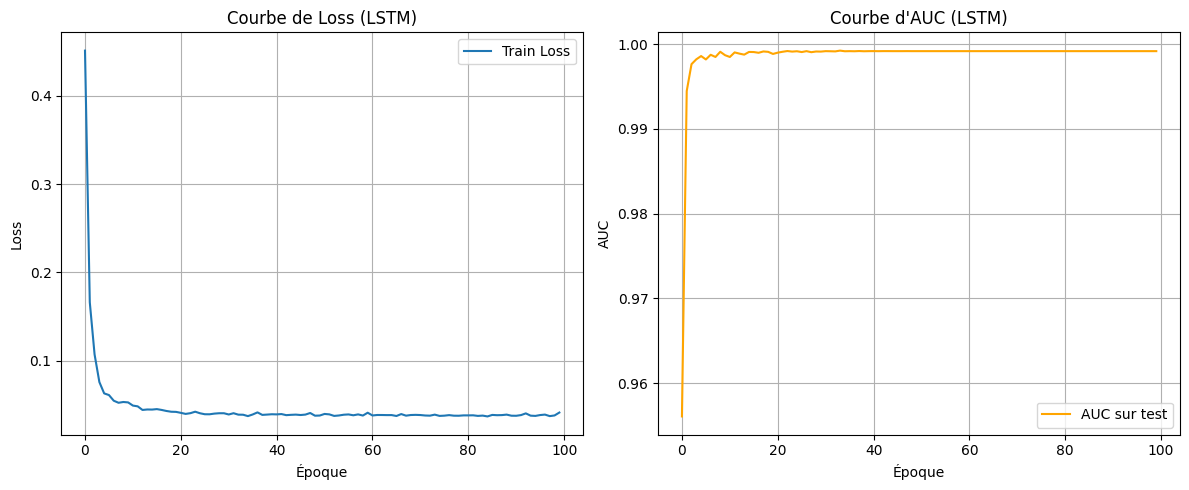

In [22]:
cnn = CNN1D()
cnn, cnn_losses, cnn_aucs = train_model(cnn, train_loader_cnn, test_loader_cnn)
plot_training_curves(cnn_losses, cnn_aucs, title=" (CNN)")

lstm = LSTM1D()
lstm, lstm_losses, lstm_aucs = train_model(lstm, train_loader_lstm, test_loader_lstm)
plot_training_curves(lstm_losses, lstm_aucs, title=" (LSTM)")

